# ML Homework 3

**Gede Ria Ghosalya - 1001841**

### Q1. Matrix Factorization

In [1]:
import numpy as np
import theano
import theano.tensor as T

learn_rate = -0.01
u = theano.shared(np.ones((3,1)), name='u')
v = theano.shared(np.ones((3,1)), name='v')
target = T.matrix(name='target')
mask = T.matrix(name='mask')

tgt = np.zeros(shape=(3,3))
tgt[0] = [0,1,0]
tgt[1] = [1,0,1]
tgt[2] = [0,1,2]

msk = np.zeros(shape=(3,3))
msk[0] = [1,1,0]
msk[1] = [1,0,1]
msk[2] = [0,1,1]

In [2]:
risk = T.sum(((T.dot(u, v.T)-target)*mask)**2)
u_grad = T.grad(risk, wrt=u)
v_grad = T.grad(risk, wrt=v)

u_train = theano.function(inputs=[],
                           outputs=risk,
                           updates=[(u, u + learn_rate*u_grad)],
                           givens={target:tgt, mask:msk})

v_train = theano.function(inputs=[],
                           outputs=risk,
                           updates=[(v, v + learn_rate*v_grad)],
                           givens={target:tgt, mask:msk})

loss = 0

for i in range(50):
    for j in range(20):
        loss = u_train()
        print('*',end="")
    for j in range(20):
        loss = v_train()
        print('+',end="")
    print('')
        
print('\nA:')
print(np.dot(u.get_value(), v.get_value().T))
print('u:\n',u.get_value())
print('v:\n',v.get_value())
print('Loss: ',loss)



********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
********************++++++++++++++++++++
****************

### Q2. Support Vector Machines

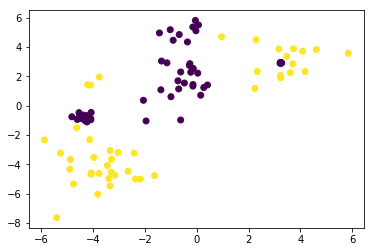

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
csv = 'https://www.dropbox.com/s/wt45tvn9ig3o7vu/kernel.csv?dl=1'
data = np.genfromtxt(csv, delimiter=',')
X = data[:,1:]
Y = data [:,0]
plt.scatter(X[:,0],X[:,1],c=Y)
plt.show()

---
**a)** Use the `sklearn.svm.SVC` module to train a kernel support vector machine via the radial basis kernel. Set gamma to 0.5 and `kernel` to `rbf`.

In [4]:
from sklearn.svm import SVC
dis_svc = SVC(gamma=0.5, kernel='rbf')
dis_svc.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

---
**b)** Evaluate the kernel SVM's decision function. You may use the `decision_function` method in `SVC`. Write a function that takes coordinates `x1, x2` and the SVC object `clf`, and return the value of decision function.

In [5]:
clf = dis_svc

def decision(x1, x2, clf):
    x = np.array([[x1, x2]])
    val = clf.decision_function(x)
    return val[0]

decision(3,5,clf)

1.1813851778172231

---
**c)** Use the following code to visualize the classifier and the data points.

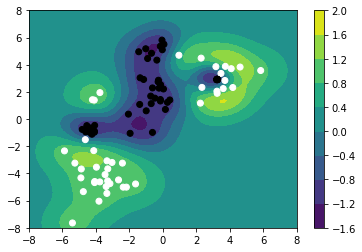

In [6]:
vdecision = np.vectorize(decision,excluded=[2])
x1list = np.linspace(-8.0, 8.0, 100)
x2list = np.linspace(-8.0, 8.0, 100)
X1, X2 = np.meshgrid(x1list, x2list)
Z = vdecision(X1, X2, clf)
cp = plt.contourf(X1, X2, Z)
plt.colorbar(cp)
plt.scatter(X[:,0], X[:,1], c=Y, cmap='gray')
plt.show()

### Q3. Deep Learning

In [7]:
%matplotlib inline
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.optimize import fmin_l_bfgs_b as minimize

from utils import normalize, tile_raster_images, sigmoid
from utils import ravelParameters, unravelParameters
from utils import initializeParameters
from utils import computeNumericalGradient

In [8]:
nV = 8*8
nH = 25
dW = 0.0001
sW = 3

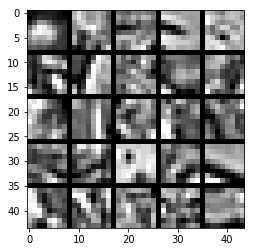

In [9]:
npy = 'images.npy'
X = normalize(np.load(npy))
plt.imshow(tile_raster_images(X=X, img_shape=(8,8), tile_shape=(5,5), 
                              tile_spacing=(1,1)),
           cmap='gray')
plt.show()

---
**a)** We implement the function which computes the cost and the gradient of the sparse autoencoder. This function will be passed to an optimization engine, together with the `theta` vector that contains the current state of all the model parameters. The first step of the function is therefore to unpack the `theta` vector into _W1, W2, b1, b2_. 

In [10]:
def sparseAutoencoderCost(theta, nV, nH, dW, sW, X):
    W1, W2, b1, b2 = unravelParameters(theta, nH, nV)
    n = X.shape[0]
    
    z2 = np.dot(X,W1) + np.dot(np.ones((n,1)),b1.T)
    a2 = sigmoid(z2)
    z3 = np.dot(a2,W2) + np.dot(np.ones((n,1)),b2.T)
    a3 = sigmoid(z3)
    
    eps = a3-X
    loss = norm(eps)**2/(2*n)
    decay = 0.5*(norm(W1)**2+norm(W2)**2)
    
    #compute sparsity terms and total cost
    rho = 0.01
    a2mean = np.mean(a2, axis=0).reshape(nH, 1)
    kl_first = rho*np.log(rho/a2mean)
    kl_last = (1-rho)*np.log((1-rho)/(1-a2mean))
    kl = np.sum(kl_first + kl_last)
    dkl = -rho/a2mean+(1-rho)/(1-a2mean)
    cost = loss+dW*decay+sW*kl
    
    d3 = eps*a3*(1-a3)
    d2 = (sW*dkl.T+np.dot(d3, W2.T))*a2*(1-a2)
    W1grad = np.dot(X.T,d2)/n + dW*W1
    W2grad = np.dot(a2.T,d3)/n + dW*W2
    b1grad = np.dot(d2.T,np.ones((n,1)))/n
    b2grad = np.dot(d3.T,np.ones((n,1)))/n
    
    grad = ravelParameters(W1grad,W2grad,
                           b1grad, b2grad)
    print(' .',end="")
    return cost, grad


In [11]:
theta = initializeParameters(nH, nV)
cost, grad = sparseAutoencoderCost(theta, nV, nH, dW, sW, X)
print(cost,grad)
#print(np.ones(50))

 .49.7204533671 [ 0.92409996  0.66995594  0.7605772  ..., -0.01799767  0.00212467
  0.00521965]


---
**b)** Compare the backdrop gradient in `sparseAutoencoderCost` with the gradient computed numerically from the cost. The relative difference should be less than 10e-9.

In [12]:
print('\nComparing numerical gradient with backdrop gradient')
num_coords = 5
indices = np.random.choice(theta.size, num_coords, replace=False)
numgrad = computeNumericalGradient(lambda t: 
                                       sparseAutoencoderCost(t,nV,nH,dW,sW,X)[0],
                                   theta,indices)
subnumgrad = numgrad[indices]
subgrad = grad[indices]
diff = norm(subnumgrad-subgrad)/norm(subnumgrad+subgrad)
print('\n',np.array([subnumgrad,subgrad]).T)
print('Relative difference: ', diff)

if diff < 10**(-9):
    print("small enough!")
else:
    print("NOOOOO!!")


Comparing numerical gradient with backdrop gradient
 . . . . . . . . . .
 [[ 0.8326458   0.8326458 ]
 [ 0.76225529  0.76225529]
 [ 0.86552561  0.86552561]
 [ 0.92709986  0.92709986]
 [-0.00107397 -0.00107397]]
Relative difference:  5.18413941778e-11
small enough!


---
**c)** Finally, run the following code to train the deep neural network and to visualize the features learnt by the autoencoder. The optimization takes several minutes.


Training neural network
 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

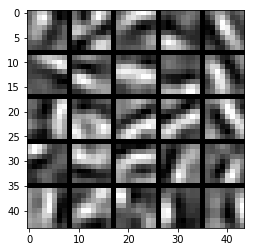

In [13]:
print('\nTraining neural network')
theta = initializeParameters(nH,nV)
opttheta,cost,msg = minimize(sparseAutoencoderCost,
                             theta,fprime=None,maxiter=400,
                             args=(nV,nH,dW,sW,X))
W1,W2,b1,b2 = unravelParameters(opttheta,nH,nV)
plt.imshow(tile_raster_images(X=W1.T, img_shape=(8,8),
                              tile_shape=(5,5),tile_spacing=(1,1)),
           cmap='gray')
plt.show()

### Q4. DataSpark Challenge

In [14]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108208 entries, 0 to 108207
Data columns (total 4 columns):
date      108208 non-null object
userid    108208 non-null object
lat       108208 non-null float64
lon       108208 non-null float64
dtypes: float64(2), object(2)
memory usage: 3.3+ MB
None


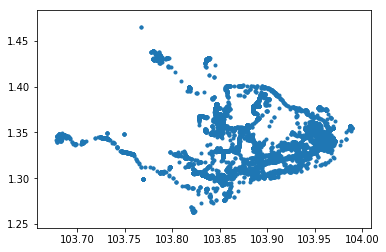

In [15]:
data = pd.read_csv('dataspark2.csv')
data = data.drop(['seqid','index','acc','dir','spd'],
                 axis=1)
print(data.info())
plt.scatter(data['lon'],data['lat'],marker='.')
plt.show()
#data = data.sample(frac=0.05, random_state=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18204 entries, 0 to 18203
Data columns (total 4 columns):
userid    18204 non-null object
date      18204 non-null datetime64[ns]
lat       18204 non-null float64
lon       18204 non-null float64
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 569.0+ KB
None


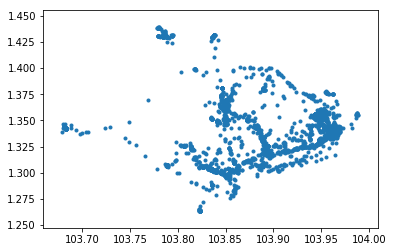

In [16]:
data['date'] = pd.DatetimeIndex(data['date']).round('5min')
data = data.groupby(['userid','date']).mean().reset_index()
print(data.info())
plt.scatter(data['lon'],data['lat'],marker='.')
plt.show()

---
**a)** Cluster the GPS locations for all users to find commonly visited places. Us the 'elbow' method to find a suitable number of clusters. Sample the data to improve speed. Write your guess for the number of clusters in the data.

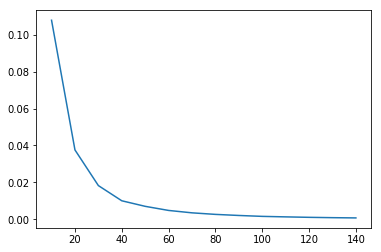

In [17]:
from sklearn.cluster import KMeans
smp = data[['lat','lon']].sample(n=3000,random_state=200)
score = []
cls_range = list(range(10,150,10))
for num_cls in cls_range:
    n_cluster = KMeans(n_clusters=num_cls).fit(smp)
    score.append(n_cluster.inertia_)
plt.plot(cls_range,score)
plt.show()

My guess is that we have 20 clusters.

---
**b)** Visualize the trained centroids. In the code below, `centroid` is a numpy array where each row consists of the latitude of some centroid.

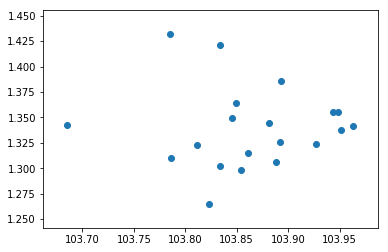

In [18]:
num_cluster = 20
data_latlon = data[['lat','lon']]
decided_kmean = KMeans(n_clusters=num_cluster).fit(data_latlon)
centroids = decided_kmean.cluster_centers_
plt.scatter(centroids[:,1],centroids[:,0])
plt.show()

---
**c)** Compute the speeds at which each user is travelling. 

In [19]:
from numpy.linalg import norm
for u in data['userid'].unique():
    user = data[data['userid']==u]
    date = pd.DatetimeIndex(user['date'])
    hour = (date-date[0])/np.timedelta64(1,'h')
    hourfor = np.append(hour[1:], hour[-1])
    dur = hourfor - hour
    
    latlon = user[['lat','lon']].get_values()
    latlonfor = np.vstack([latlon[1:],latlon[-1]])
    displacement = (latlonfor - latlon)**2
    disp_p = (displacement[:,0] + displacement[:,1])**0.5
    
    speed = 111*disp_p/dur
    data.loc[data['userid']==u,'speed'] = speed

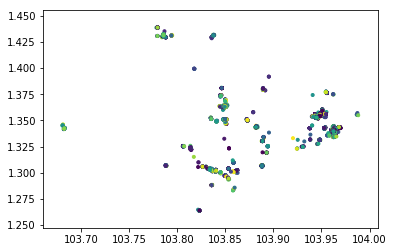

Number of entries = 14135


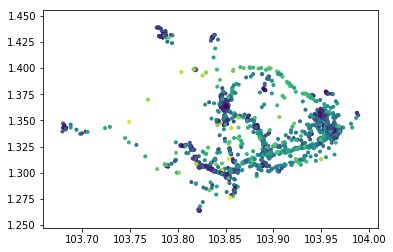

Number of entries = 4059


In [20]:
stop = data[data['speed']<1]
plt.scatter(stop['lon'],stop['lat'],
            c=np.log(stop['speed']+1),
            marker='.')
plt.show()
print('Number of entries =',stop.shape[0])

move = data[data['speed']>=1]
plt.scatter(move['lon'],move['lat'],
            c=np.log(move['speed']+1),
            marker='.')
plt.show()
print('Number of entries =',move.shape[0])